Nome:

RA:

Curso:



# Ex05 - Classificação de imagens usando rede neural convolucional (CNN)

O objetivo principal deste notebook é ilustrar e praticar o uso de redes neurais convolucionais (CNNs) para tarefas de classificação de imagens. Em relação às redes neurais convencionais, as CNNs geralmente apresentam a vantagem de possuir menos parâmetros a serem aprendidos. Além disso, as CNNs são particularmente adequadas para trabalhar com imagens devido à sua arquitetura projetada para lidar com dados espaciais de forma eficiente.

Tomaremos como base a biblioteca PyTorch, que segue uma abordagem de programação orientada a objetos. Além dela, recomendamos o uso de outras bibliotecas relacionadas (como o PyTorch Lightning) que auxiliam e simplificam etapas do framework. Note que algumas destas bibliotecas podem não estar disponíveis por padrão no Colab, sendo necessária sua instalação (como exemplificado na próxima célula de código).

Para mais informações sobre redes convolucionais, exemplos e boas práticas, recomendamos os materiais de apoio às aulas 5 e 6 disponibilizados no classroom. Lá você vai encontrar um tutorial teórico sobre CNN, além de tutoriais práticos disponibilizados no GitHub, vídeos e links de apoio. Em especial, o tutorial prático de classificação com CNN ([link](https://colab.research.google.com/drive/1uXLYbWwHT8cChAYmexV6QNUi5eI4ITod?usp=sharing)) pode ser de grande ajuda.

**Atenção!** Não se esqueça de utilizar a GPU do Colab (clique em "Ambiente de execução" e "Alterar o tipo de ambiente de execução", selecione a GPU).

In [ ]:
# Instalando bibliotecas no Colab
!pip install pytorch-lightning torchinfo torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
# Importando as bibliotecas que serão utilizadas
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import random
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchmetrics import Accuracy
import torchinfo
from torchsummary import summary
import multiprocessing as mp
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%load_ext tensorboard

# Definindo o nome da pasta compartilhada
# IMPORTANTE: substitua "NOME_DA_PASTA_COMPARTILHADA" abaixo pelo nome correspondente
pasta_compartilhada = "NOME_DA_PASTA_COMPARTILHADA"

In [ ]:
# Conexão do colab com o drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Parte 1 - Exemplo de classificação com o MNIST

Exemplificaremos algumas das etapas do framework de classificação com CNN utilizando o conjunto de dados MNIST (Modified National Institute of Standards and Technology database), um grande conjunto de dados de dígitos manuscritos comumente usado na área de aprendizado de máquina. Ele consiste de 60.000 imagens de treinamento e 10.000 images de teste (que, no nosso exemplo, serão utilizadas para validação). As imagens do conjunto são de 28x28 pixels. Uma descrição completa do conjunto de dados pode ser encontrada [aqui](https://en.wikipedia.org/wiki/MNIST_database).

### Leitura dos dados

Idealmente, códigos para processar amostras de dados devem estar desacoplados do código do treinamento do modelo, facilitando sua legibilidade e modularidade. O PyTorch fornece duas primitivas de dados ([torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) e [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) que facilitam a leitura, processamento e organização dos dados para entrada no modelo. Mais informações sobre Datasets e DataLoaders podem ser encontradas [aqui](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) e [aqui](https://blog.paperspace.com/dataloaders-abstractions-pytorch/).

In [ ]:
# Carregando os dados utilizando torchvision.datasets e convertendo as imagens para tensores
training_data = datasets.MNIST(
    root="data_mnist",
    train=True,
    download=True,
    transform=ToTensor()
)
val_data = datasets.MNIST(
    root="data_mnist",
    train=False,
    download=True,
    transform=ToTensor()
)

print(training_data)
print()
print(val_data)
print()
print("*Note que, apesar de identificado como teste, utilizaremos o segundo conjunto de dados para validação!")

100%|██████████| 9912422/9912422 [00:00<00:00, 38662851.98it/s]


Extracting data_mnist\MNIST\raw\train-images-idx3-ubyte.gz to data_mnist\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]

Extracting data_mnist\MNIST\raw\train-labels-idx1-ubyte.gz to data_mnist\MNIST\raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25060119.85it/s]


Extracting data_mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to data_mnist\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting data_mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to data_mnist\MNIST\raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: data_mnist
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: data_mnist
    Split: Test
    StandardTransform
Transform: ToTensor()

*Note que, apesar de identificado como teste, utilizaremos o segundo conjunto de dados para validação!


**É sempre importante checar e visualizar os dados a cada etapa do framework de classificação, garantindo que eles estão de acordo com o esperado e evitando a propagação de erros.**

2
<class 'torch.Tensor'> <class 'int'>
Shape da imagem: torch.Size([1, 28, 28])
Label: 3
Maior valor de intensidade da imagem: tensor(1.)
Menor valor de intensidade da imagem: tensor(0.)


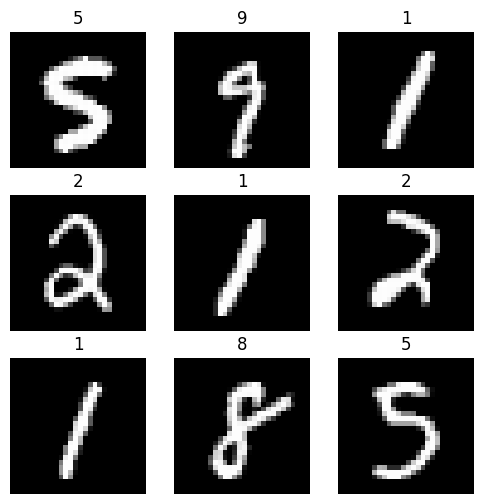

In [ ]:
# Checando informações de uma amostra de treinamento
training_example = random.choice(training_data)
print(len(training_example))
print(type(training_example[0]), type(training_example[1]))
print('Shape da imagem:', training_example[0].shape)
print('Label:', training_example[1])
print('Maior valor de intensidade da imagem:', torch.max(training_example[0]))
print('Menor valor de intensidade da imagem:', torch.min(training_example[0]))

# Visualizando algumas imagens e labels do conjunto de treinamento
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = random.choice(training_data)
    plt.subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray", vmin=0, vmax=1)
plt.show()

2
<class 'torch.Tensor'> <class 'int'>
Shape da imagem: torch.Size([1, 28, 28])
Label: 2
Maior valor de intensidade da imagem: tensor(0.9961)
Menor valor de intensidade da imagem: tensor(0.)


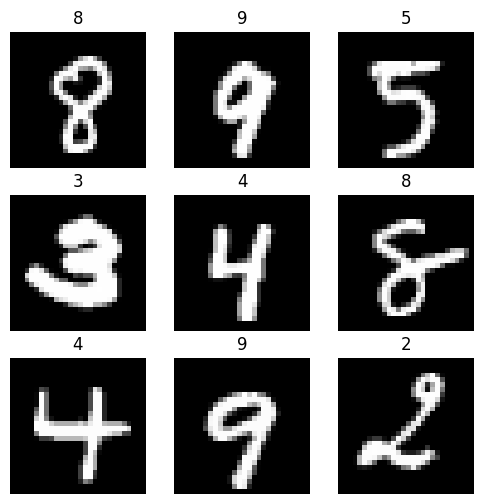

In [ ]:
# Checando informações de uma amostra de validação
val_example = random.choice(val_data)
print(len(val_example))
print(type(val_example[0]), type(val_example[1]))
print('Shape da imagem:', val_example[0].shape)
print('Label:', val_example[1])
print('Maior valor de intensidade da imagem:', torch.max(val_example[0]))
print('Menor valor de intensidade da imagem:', torch.min(val_example[0]))

# Visualizando algumas imagens e labels do conjunto de validação
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = random.choice(val_data)
    plt.subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray", vmin=0, vmax=1)
plt.show()

### Exercício 1.1

Explique o processamento aplicado pela classe torchvision.transforms.ToTensor às imagens do conjunto. Explique também porque foi necessário utilizar o .squeeze() para visualizar as imagens e qual a sua função.

RESPOSTA:

### Hiperparâmetros

É interessante utilizar um dicionário de hiperparâmetros para organizar o código, evitar "números mágicos" e registrar as configurações de cada experimento realizado.

In [ ]:
hparams = {"experiment_name": "Test_ResNet_1",  # experiment name identifies the run for later
           "max_epochs": 10,  # number of epochs to train
           "batch_size": 100,  # size of batch
           "nworkers": mp.cpu_count(),  # number of workers to use in parallel loading
           "nout": 10,  # number of classes
           "nin": 1,  # number of channels of the input image
           "lr": 1e-4,  # learning rate
           "wd": 1e-5,  # weight decay for optimizer
           "cpu": False,  # forces using the CPU
           }

for k, v in hparams.items():
    print(f"{k}: {v}")

experiment_name: Test_ResNet_1
max_epochs: 10
batch_size: 100
nworkers: 8
nout: 10
nin: 1
lr: 0.0001
wd: 1e-05
cpu: False


### Data Module

A classe [pytorch_lightning.LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) pode ser utilizada para organizar os DataLoaders e os dados.

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)

    def setup(self, stage=None):
        self.train = training_data
        self.val = val_data

    '''
    Dataloaders optimize data loading and automatically prepare batches
    '''
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.hparams.batch_size, num_workers=self.hparams.nworkers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.hparams.batch_size, num_workers=self.hparams.nworkers, shuffle=False)

**Novamente, checamos os dados obtidos através do DataModule.**

Shape do batch: torch.Size([100, 1, 28, 28])


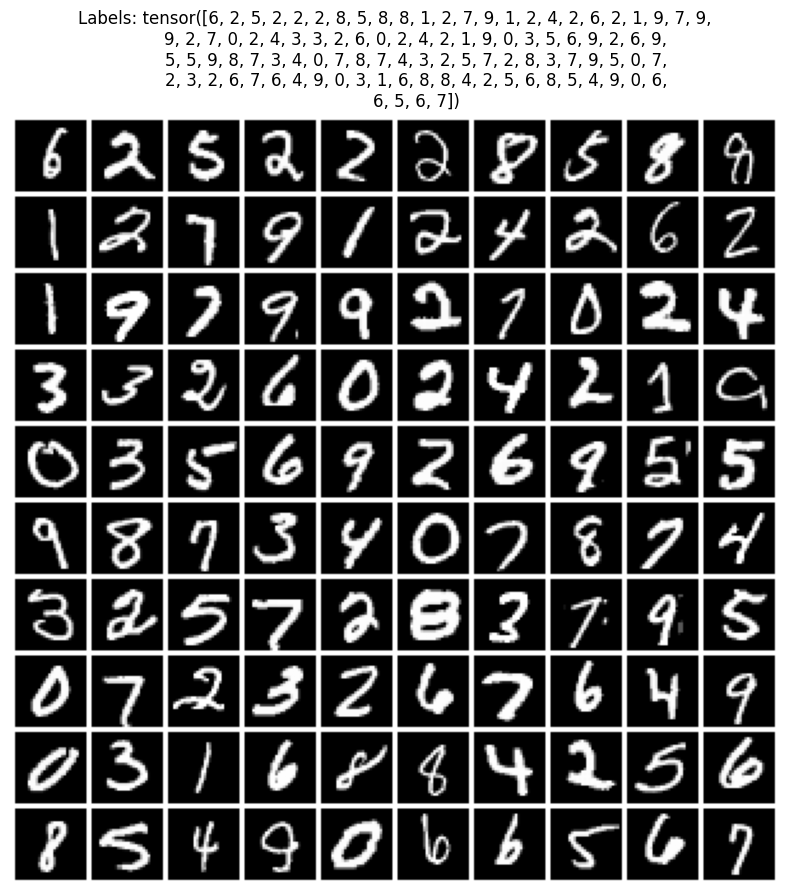

In [ ]:
# DEBUG DATA MODULE
data_module = MNISTDataModule(hparams)
data_module.setup()

dataloader = data_module.train_dataloader()
img_batch, label_batch = next(iter(dataloader))
print("Shape do batch:", img_batch.shape)

img_grid = make_grid(img_batch, nrow=10, pad_value=1)
fig = plt.figure(figsize=(10,10))
plt.imshow(img_grid.permute(1, 2, 0).numpy())
plt.title(f'Labels: {label_batch}')
plt.axis('off')
plt.show()

### Definindo a CNN

No código abaixo, é criado um modelo baseado na [Resnet-18](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html). O mesmo será treinado **sem transfer learning** e com uma inicialização randômica dos pesos. Visualizamos também todas as camadas (layers) que compõem o modelo e seus parâmetros.

In [ ]:
cnn_model = models.resnet18(weights=None)
print(cnn_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
cnn_model.conv1 = nn.Conv2d(hparams['nin'], 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = cnn_model.fc.in_features
cnn_model.fc = nn.Linear(num_ftrs, hparams['nout'])
print(cnn_model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Exercício 1.2

Para que serve cada camada da rede? Por que foi necessário modificar ligeiramente a rede (célula anterior) e que modificações foram realizadas?

RESPOSTA:

### Resumo do modelo

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
cnn_model.to(device)
summary(cnn_model, (1, 28, 28))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,136
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14            

### Exercício 1.3

Tente entender as dimensões da saída de cada camada da rede. Por exemplo, porque as três primeiras camadas possuem saídas com dimensões (-1, 64, 14, 14) e a quarta camada tem saída com dimensões (-1, 64, 7, 7)?

E quanto aos parâmetros a serem aprendidos, você consegue explicar como eles são calculados?

RESPOSTA:

### Lightning Module

Aqui definimos o comportamento durante o treinamento, ou seja, o que acontece com um lote retornado pelo DataLoader.

In [ ]:
class TrainMNIST(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.save_hyperparameters(hparams)
        self.model = cnn_model
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.hparams.nout)

        torchinfo.summary(self.model)

    def forward(self, x):
        return self.model(x).softmax(dim=-1)

    def classification_step(self, mode, batch):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)

        if mode == "train":
            self.log("loss", loss, on_epoch=True, on_step=True)
            return loss
        elif mode == "val":
            _, preds = torch.max(y_hat, 1)
            self.accuracy(preds, y)
            self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
            self.log("val_acc", self.accuracy, on_epoch=True, on_step=False, prog_bar=True)

    def training_step(self, train_batch, batch_idx):
        return self.classification_step("train", train_batch)

    def validation_step(self, val_batch, batch_idx):
        self.classification_step("val", val_batch)

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd)

        return optimizer

### Treinando a CNN

In [ ]:
debug = False  # Turn this True to test the code with a quick run

# Initialization
model = TrainMNIST(hparams)
data = MNISTDataModule(hparams)

# The PL trainer can run various callbacks during training. Here we only use the
# callback that saves the weights of the trained network.
os.makedirs("logs", exist_ok=True)
checkpoint_callback = [ModelCheckpoint(dirpath="logs",  # path to save checkpoint
                                       filename=hparams["experiment_name"] + "-{epoch}-{val_acc:.2f}",
                                       monitor="val_acc",
                                       mode="max")]

trainer = pl.Trainer(max_epochs=hparams["max_epochs"],
                     fast_dev_run=debug,
                     callbacks=checkpoint_callback,
                     log_every_n_steps=1
                     )

print("Hyperparameters:\n")
for k, v in hparams.items():
    print(f'{k}: {v}')

trainer.fit(model, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: d:\Caio\Doutorado\PED_EA979\Exercicios\EA979-IA905-2024S1\Exercicios_Proc_Img_2024S1\lightning_logs


Hyperparameters:

experiment_name: Test_ResNet_1
max_epochs: 10
batch_size: 100
nworkers: 8
nout: 10
nin: 1
lr: 0.0001
wd: 1e-05
cpu: False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNet             | 11.2 M
1 | loss     | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\caios\anaconda3\envs\New_EA979\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\caios\anaconda3\envs\New_EA979\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Visualizando os logs de treinamento

Por padrão, o Pytorch Lightning registra os resultados do treinamento usando o TensorBoard. Você pode configurar muitos outros registradores (https://pytorch-lightning.readthedocs.io/en/stable/extensions/logging.html), recomendamos verificar o Neptune ou o MLFlow. Utilize esses registradores para comparar experimentos!

Abaixo é possível verificar os resultados do treinamento realizado previamente (disponibilizado no diretório **Dados/Ex05/saved_lightning_logs**).

In [ ]:
path = f"gdrive/MyDrive/{pasta_compartilhada}/Dados/Ex05/saved_lightning_logs"
%tensorboard --logdir {path}

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

### Análise dos resultados

Após o treinamento da rede, é importante checar os resultados de validação, visualizando algumas saídas da rede e obtendo métricas de classificação. Abaixo exemplificamos a visualização da matriz de confusão utilizando o checkpoint de um trinamento realizado previamente (disponibilizado no diretório **Dados/Ex05/saved_logs**).

In [ ]:
# WARNING: This will load a random checkpoint from the logs folder, if you want an specific one change it!
baseline_model = random.choice(glob(f"gdrive/MyDrive/{pasta_compartilhada}/Dados/Ex05/saved_logs/*.ckpt"))
print(f"Using model {baseline_model}")

# Load trained model
model = TrainMNIST.load_from_checkpoint(baseline_model).eval().cuda()

# Initialize validation data
data = MNISTDataModule(hparams)
data.setup()
data.hparams.batch_size = 1
val_data = data.val_dataloader()

def collect_2d_results(data, model):
    y_trues = []
    y_labels = []
    for (img, label) in data:
        with torch.no_grad():
            out = model(img.cuda()).argmax(dim=-1).item()

        label = label.numpy()
        y_trues.append(label)
        y_labels.append(out)

    return y_trues, y_labels

y_trues_val, y_labels_val = collect_2d_results(val_data, model)

Using model logs\Test_ResNet_1-epoch=7-val_acc=0.99.ckpt


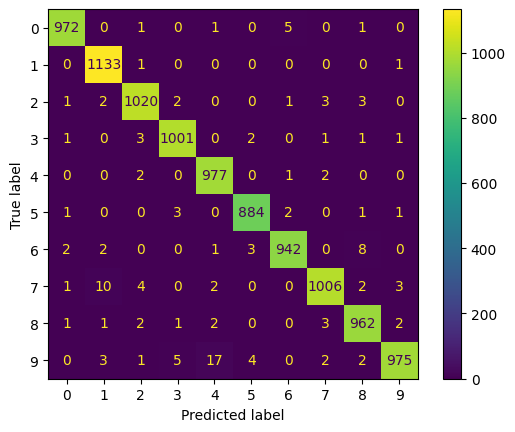

In [ ]:
# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_trues_val, y_labels_val, labels=np.arange(10)),
                                display_labels=np.arange(10))
fig = disp.plot(ax=None).figure_
plt.show()

Por fim, o modelo final seria avaliado em um conjunto de teste (que não está disponível no exemplo apresentado). **Vale ressaltar que o conjunto de teste não deve ser utilizado para refinar o modelo! Ele deve ser utilizado apenas para uma avaliação final do modelo.**

## Parte 2 - Classificação com o DermaMNIST

Vamos retomar a classificação do dataset de imagens dermatoscópicas de lesões de pele comuns, utilizado no Exercício 02. Desta vez, ao invés de extrair os atributos "artesanalmente" e classificar com o KNN, utilizaremos CNNs para realizar os dois processos simultaneamente (extração de atributos + classificação).

**Dataset**

O dataset consiste em 600 imagens de lesões de pele, obtidas ao longo de 20 anos em dois hospitais diferentes. Como as imagens foram obtidas e armazenadas de diferentes formas ao longo do tempo (armazenadas em arquivos PowerPoint, por exemplo), elas passaram por um processo de seleção, organização e padronização para compor o dataset. Assim, as imagens foram cortadas em torno das lesões de modo a deixá-las centralizadas e, em alguns casos, tiveram seus histogramas corrigidos manualmente para melhorar o contraste visual e a reprodução de cores.

As imagens estão divididas em dois tipos de lesão de pele:
- 300 casos de carcinoma basocelular (label 0) - um tipo de câncer de pele que começa nas células basais, raramente apresenta metástase, mas cresce de forma destrutiva se não tratado;
- 300 casos de melanoma (label 1) - o tipo mais grave de câncer de pele, que começa nas células produtoras de melanina, é quase sempre curável em estágios iniciais, mas tende a apresentar metástase com o tempo.

O dataset está separado em um conjunto de treino com 400 imagens (200 de cada classe), um conjunto de validação com 100 imagens (50 de cada classe) e um conjunto de teste com 100 imagens (50 de cada classe). As imagens devem ser classificadas em 0 ou 1, representando os dois tipos de lesões presentes no dataset (carcinoma ou melanoma, respectivamente).

### Exercício 2.1

Com base no exemplo apresentado e nos materiais de apoio disponibilizados, treine uma CNN para classificar as lesões de pele. O dataset está disponível no diretório **Dados/Ex05/Derma_MNIST_Dataset**. Considere as recomendações abaixo:

- Para a leitura dos dados, você pode criar um [Dataset customizado](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) ou ainda utilizar a classe [torchvision.datasets.ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html).
- Considere aplicar [transformações](https://pytorch.org/vision/stable/transforms.html) durante a leitura dos dados, seja para normalizá-los ou realizar aumentação de dados.
- Lembre-se de sempre checar os dados!
- Você pode definir sua própria rede ou utilizar modelos de classificação disponibilizados pelo PyTorch (como a [ResNet](https://pytorch.org/vision/stable/models/resnet.html) ou a [EfficientNet](https://pytorch.org/vision/stable/models/efficientnet.html)). Caso utilize modelos disponibilizados, tome cuidado com as entradas e saídas da rede, talvez seja necessário realizar algumas modificações (como no exemplo apresentado). Considere também a utilização de modelos pré-treinados, eles apresentam resultados melhores do que modelos inicializados com pesos randômicos?
- Note que, no exemplo apresentado, os checkpoints da rede e os logs do PyTorch Lightning ficam salvos no ambiente de execução do Colab. Tome cuidado para não acabar perdendo experimentos! Você pode alterar o local em que esses arquivos são salvos para que sejam armazenados no seu Drive ou ainda salvar manualmente os arquivos que julgar importantes.
- Tente modificar os hiperparâmetros para obter melhores resultados de validação.
- Verifique os resultados do modelo: visualize algumas saídas da rede e obtenha métricas de classificação (acurácia, precisão, revocação e F1-score), além de imprimir a matriz de confusão.
- Idealmente, você deve avaliar apenas o modelo final no conjunto de teste.

Comente os métodos utilizados e resultados obtidos, tentando justificar as decisões que foram tomadas. Compare também os resultados obtidos através da CNN com os resultados obtidos através do KNN no Exercício 02.

In [ ]:
# Seu código aqui

## Parte 3 - Classificação com o DermaMNIST original (opcional para EA979)

### Exercício 3.1

Treine novamente o modelo final do exercício anterior, mas dessa vez utilize o conjunto original de dados do DermaMNIST.

Os dados estão armazenado no arquivo "dermamnist.npz", no diretório **Dados/Ex05** (arquivos deste tipo já foram explorados no parte 5 do Exercício 01). **Note que o conjunto original de dados possui 7 classes distintas, mas estamos interessados apenas em duas classes: casos de carcinoma basocelular (label 1) e melanoma (label 4).** Portanto, você deve filtrar e organizar os dados para que eles sejam utilizados na classificação.

Verifique a quantidade de amostras de cada classe de interesse nos conjuntos de treino, validação e teste. Você deve notar que as duas classes estão desbalanceadas. Busque alternativas para lidar com esse desbalanceamento. Após aplicar as modificações os resultados da rede melhoraram?

Não se esqueça de comentar sobre os métodos utilizados e resultados obtidos, tentando justificar as decisões que foram tomadas.

In [ ]:
# Seu código aqui